In [94]:
import gym
from gym import spaces
from gym.utils import seeding


In [95]:
import pandas as pd
import numpy as np
import typing
from datetime import datetime

In [96]:
import ray
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=10, ignore_reinit_error=True, log_to_driver=False)

2020-11-22 09:32:15,267	ERROR worker.py:643 -- Calling ray.init() again after it has already been called.


In [97]:

def load_data(
    price_source: str, 
    tickers: typing.List[str],
    start: datetime, 
    end: datetime, 
    features: typing.List[str],
):
    """Returned price data to use in gym environment"""
    # Load data
    # Each dataframe will have columns date and a collection of fields
    # TODO: DataLoader from mongoDB
    # Raw price from DB, forward impute on the trading days for missing date
    # calculate the features (log return, volatility)
    if price_source in ["csvdata"]:
        feature_df = []
        for t in tickers:
            df1 = pd.read_csv("csvdata/{}.csv".format(t))
            df1['datetime'] = pd.to_datetime(df1['datetime'])
            df1 = df1[(df1['datetime']>=start) & (df1['datetime']<=end)]
            df1.set_index("datetime",inplace=True)
            selected_features = ['return','tcost'] + features
            feature_df.append(df1[selected_features])
            ref_df_columns = df1[selected_features].columns

    # assume all the price_df are aligned and cleaned in the DataLoader
    merged_df = pd.concat(feature_df, axis=1, join="outer")
    # Imputer missing values with zeros 
    price_tensor = merged_df['return'].fillna(0.0).values
    tcost = merged_df['tcost'].fillna(0.0).values

    return {
        "dates": merged_df.index,
        "fields": ref_df_columns,
        "data": merged_df.fillna(0.0).values,
        "pricedata": price_tensor,
        "tcost": tcost,
    }


In [98]:
load_data('csvdata',['SPY','QQQ',], datetime(2010, 5, 4), datetime(2020, 12, 31), ["volatility_20", "skewness_20", "kurtosis_20"] ) ['data'][:10,:]

array([[-2.36998991e-02,  4.25369008e-05,  1.09934270e-02,
        -9.14812793e-01, -2.61064489e-01, -3.01849936e-02,
         1.03231135e-04,  1.16465557e-02, -1.10048552e+00,
         5.96949184e-01],
       [-5.94984959e-03,  4.27953952e-05,  1.09991806e-02,
        -9.10788716e-01, -2.70376218e-01, -5.12061786e-03,
         1.03745202e-04,  1.16723407e-02, -9.95452223e-01,
         4.23777969e-01],
       [-3.36369023e-02,  4.42928644e-05,  1.30807177e-02,
        -9.16682320e-01, -2.54900342e-01, -3.36202334e-02,
         0.00000000e+00,  1.37192261e-02, -9.68839072e-01,
        -4.24718444e-02],
       [-1.49229482e-02,  4.49216118e-05,  1.31754036e-02,
        -7.10326792e-01, -5.75516042e-01, -2.49435926e-02,
         0.00000000e+00,  1.45399702e-02, -7.26873145e-01,
        -6.77999658e-01],
       [ 4.29173814e-02,  4.30496362e-05,  1.66156842e-02,
         3.64864054e-01,  7.49281745e-01,  5.01088321e-02,
         1.04701078e-04,  1.85963149e-02,  4.85487538e-01,
         1.

In [136]:
from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return
from sklearn.preprocessing import StandardScaler 

class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'],env_config['features'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        #self.n_features = self.n_assets_fields * len(self.tickers)
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features,1), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        # Trade every 10 days 
        # Normalise action space 
        if self.index % 10 == 0:
            normalised_action = action / np.sum(np.abs(action))
            self.actions = normalised_action
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(self.actions,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [self.actions], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(self.actions[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        recent_series = pd.Series(self.log_return_series)[-100:]
        rolling_volatility = np.std(recent_series)
        self.metric = today_portfolio_return / rolling_volatility 
        reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0                    
        self.index = self.lookback
        self.actions = np.zeros(shape=self.n_assets)
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        price_lookback = self.featuredata[self.index-self.lookback:self.index,:]
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        positions = self.position_series[self.index-self.lookback:self.index]
        scaler = StandardScaler()
        price_lookback = scaler.fit_transform(price_lookback)
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation.reshape((observation.shape[0], observation.shape[1], 1))
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self, new_action, old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        fees = np.array(list(fees) + [0.9995])
        tcost = turnover * np.log(fees)
        return tcost 

In [100]:
config = {'pricing_source':'csvdata', 'tickers':['BRK','TLT','QQQ','GLD',], 
          'lookback':10, 'start':'2008-01-02', 'end':'2018-12-31', 'features':["volatility_20", "skewness_20", "kurtosis_20"]}
EQ_env = Equitydaily(config)

In [101]:
EQ_env.observation.shape, EQ_env.n_features

((10, 27, 1), 20)

In [102]:
EQ_env.observation

array([[[-0.46623792],
        [-0.53317207],
        [-0.6065899 ],
        [-1.90618101],
        [ 2.16042431],
        [ 1.52550903],
        [-0.87140677],
        [ 1.31492554],
        [ 1.26956813],
        [-1.38604284],
        [-0.1689315 ],
        [ 0.67833654],
        [-2.42229207],
        [ 0.69360279],
        [-1.00745854],
        [ 1.55595835],
        [-0.34534522],
        [ 0.60420498],
        [-0.71944688],
        [-0.43106563],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-1.06752807],
        [-0.69607796],
        [ 0.34712032],
        [-0.98516115],
        [-0.08524695],
        [-0.62235964],
        [ 1.32476134],
        [ 1.31857015],
        [ 1.33850772],
        [-1.35020668],
        [-1.59973366],
        [ 0.73023773],
        [-0.21286845],
        [-1.69979899],
        [ 1.299592  ],
        [-0.10455638],
        [

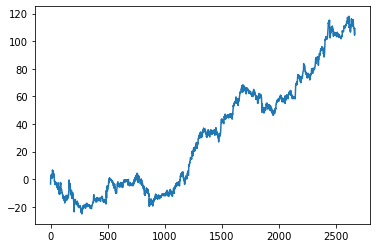

In [103]:
state = EQ_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([1,0,0,0,0])
    state, reward, done, future_price = EQ_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(reward_list).cumsum().plot()

PPO policy

In [137]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [138]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 20
config["train_batch_size"] = 5000
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 20
config['sgd_minibatch_size'] = 200
config['model']['dim'] = 200
config['model']['conv_filters'] = [[32, [5, 1], 5], [32, [5, 1], 5], [4, [5, 1], 5]]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = {'pricing_source':'csvdata', "tickers": ["BRK_A", "GE_","GOLD_", "AAPL_","GS_","T_",],
          'lookback':200, 'start':'1995-01-02', 'end':'2018-12-31', 'features':["return_volatility_20", "return_skewness_20", "return_kurtosis_20"]}

In [139]:
config

{'num_workers': 1,
 'num_envs_per_worker': 1,
 'rollout_fragment_length': 20,
 'batch_mode': 'complete_episodes',
 'num_gpus': 0,
 'train_batch_size': 5000,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': [[32, [5, 1], 5], [32, [5, 1], 5], [4, [5, 1], 5]],
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  '_time_major': False,
  'framestack': True,
  'dim': 200,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_action_dist': None,
  'custom_preprocessor': None},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {'pricing_source': 'csvdata',
  'tickers': ['BRK_A', 'GE_', 'GOLD_', 'AAPL_', 'GS_', 'T_'],
  'lookback': 200,
  'start': '1995-01-02',
  'end': '2018-1

Check to see if agents can be trained

In [140]:
agent = PPOTrainer(config, Equitydaily)
best_reward = -np.inf

2020-11-22 10:17:18,772	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [141]:
for i in range(2):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 10:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

sampleagent/checkpoint_1/checkpoint-1
-169.59557785100353


In [ ]:
result

In [ ]:
agent.restore('sampleagent/checkpoint_1/checkpoint-1')

In [78]:
for i in range(5):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 1:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

sampleagent/checkpoint_4/checkpoint-4
-535.9323429076005
sampleagent/checkpoint_5/checkpoint-5
-526.1276376951023
sampleagent/checkpoint_7/checkpoint-7
-522.2019039406775


In [79]:
result

{'episode_reward_max': -415.02074011362794,
 'episode_reward_min': -633.5108483329875,
 'episode_reward_mean': -522.2019039406775,
 'episode_len_mean': 2627.0,
 'episodes_this_iter': 2,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'custom_metrics': {},
 'hist_stats': {'episode_reward': [-539.1598334863469,
   -469.06551439816803,
   -562.9823075709035,
   -523.5588877487897,
   -570.4579153419675,
   -549.8358615276551,
   -633.5108483329875,
   -415.02074011362794,
   -460.29247088179636,
   -571.7997117430767,
   -502.9626815458952,
   -470.85495214432393,
   -480.83164749398276,
   -560.4932828399646],
  'episode_lengths': [2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627]},
 'sampler_perf': {'mean_env_wait_ms': 0.9928205776032585,
  'mean_raw_obs_processing_ms': 0.09451218710168378,
  'mean_inference_ms': 0.8205471140632769,
  'mean_action_processing_ms': 0.08131409539686671}

SAC 

In [ ]:
from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [ ]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1

config["rollout_fragment_length"] = 10
config["train_batch_size"] = 50
config["timesteps_per_iteration"] = 10
config["buffer_size"] = 10000

config["Q_model"]["fcnet_hiddens"] = [10, 10]
config["policy_model"]["fcnet_hiddens"] = [10, 10]
config["num_cpus_per_worker"] = 2 
config["env_config"] = {
    "pricing_source": "csvdata",
    "tickers": ["QQQ", "EEM", "TLT", "SHY", "GLD", "SLV"],
    "lookback": 1,
    "start": "2007-01-02",
    "end": "2015-12-31",
}

In [ ]:
# Train agent 
agent = SACTrainer(config, Equitydaily)
best_reward = -np.inf

In [ ]:
for i in range(20):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
    print(result['episode_reward_mean'])

In [ ]:
result

Run environment 

In [ ]:
config

In [ ]:
agent = PPOTrainer(config, Equitydaily)

In [ ]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','EEM'], 'lookback':50, 'start':'2011-01-02', 'end':'2020-12-31'})

In [ ]:
agent.restore('checkpoint_1087/checkpoint-1087')

In [ ]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([0,0,0,0,0,0,1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
pd.Series(reward_list).plot()

In [ ]:
pd.DataFrame(actions)

Run environment for RNN environment

In [ ]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ'], 'lookback':50, 'start':'2018-01-02', 'end':'2020-12-31'})

state = env.reset()
done = False
cum_reward = 0 
actions = list()

rnn_state = agent.get_policy().get_initial_state()

while not done:
    action, rnn_state, _ = agent.compute_action(state,rnn_state)
    #action = np.array([1,-1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(actions)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
max_drawdown(pd.Series(env.log_return_series))

In [ ]:
annual_return(pd.Series(env.log_return_series))

In [ ]:
class Equitydaily_v1(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        normalised_action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(normalised_action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [normalised_action], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(normalised_action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        live_days = self.index - self.lookback
        burnin = 250
        recent_series = pd.Series(self.log_return_series)[-100:]
        whole_series = pd.Series(self.log_return_series)
        if live_days > burnin: 
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series)
        else:
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series) *live_days / burnin
        reward = self.metric - self.metric_series[-1]
        #reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {'current_price':next_day_log_return}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0                    
        self.index = self.lookback
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        price_lookback = self.featuredata[self.index-self.lookback:self.index,:]
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        positions = self.position_series[self.index-self.lookback:self.index]
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation 
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        tcost = turnover * np.log(fees)
        return tcost 